In [1]:
import matplotlib.pyplot as plt
from polysimplify import VWSimplifier

In [2]:
import platform
platform.python_version()

'3.5.2'

In [3]:
import numpy as np
from time import time

n = 5000
thetas = np.linspace(0,2*np.pi,n)
pts = np.array([[np.sin(x),np.cos(x)] for x in thetas])

start=time()
simplifier = VWSimplifier(pts)
VWpts = simplifier.from_number(n/20)
end = time()
print("Visvalingam: reduced to %s points in %03f seconds" %(len(VWpts),end-start))
#50 points in .131 seconds on my computer

Visvalingam: reduced to 250 points in 0.169223 seconds


In [16]:
np.shape(pts)

(5000, 2)

# Hranice oblasti

In [41]:
#possible boundary solution

import fiona
import pylab as pl
import shapely.geometry as geometry
from descartes import PolygonPatch
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
from rdp import rdp

def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.p
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
    coords = np.array([point.coords[0] for point in points])
    alpha=alpha/(max(coords[:,0])-min(coords[:,0])+max(coords[:,1])-min(coords[:,1]))*2
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
#         print(circum_r)
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles)

def plot_polygon(polygon):
    fig = pl.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3
    x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig

def oneCall(p,alpha):
    global concave_hull
    concave_hull = alpha_shape(p,alpha)
    plot_polygon(concave_hull)
    x = [point.coords.xy[0] for point in p]
    y = [point.coords.xy[1] for point in p]
    pl.plot(x,y,'x', color='#f16824')
    pl.show()
    return False

def straightenBoundary(input_shapefile):
    shapefile = fiona.open(input_shapefile)
    points = [geometry.shape(point['geometry'])
          for point in shapefile]
    print("Input alpha value 'n' to break the loop");
    while True:
        alpha=eval(input("(float) alpha = "))
        if (alpha=="n"):
            break
        try:
            alpha=float(alpha)
        except:
            print("Unable to convert input as float value!")
            break
        oneCall(points,alpha)
    print("Concave hull output straightened boundary:")
    arr = np.array(concave_hull.boundary.xy)
    pl.plot(arr[0,:],arr[1,:])
    pl.show()
    return arr.T

def simplifyBoundary(arr):
    print("Input alpha value 'n' to break the loop");
    while True:
        eps=eval(input("(float) epsilon: "))
        if (eps=="n"):
            break
        try:
            eps=float(eps)
        except:
            print("Unable to convert input as float value!")
            break
        new=rdp(arr,epsilon=eps)
        print(("Number of boundary points: ",new.shape[0]))
        pl.plot(new[:,0],new[:,1])
        pl.show()
    print("Final output simplified boundary:")
    pl.plot(new[:,0],new[:,1])
    pl.show()
    return new

Input alpha value 'n' to break the loop
(float) alpha = 50


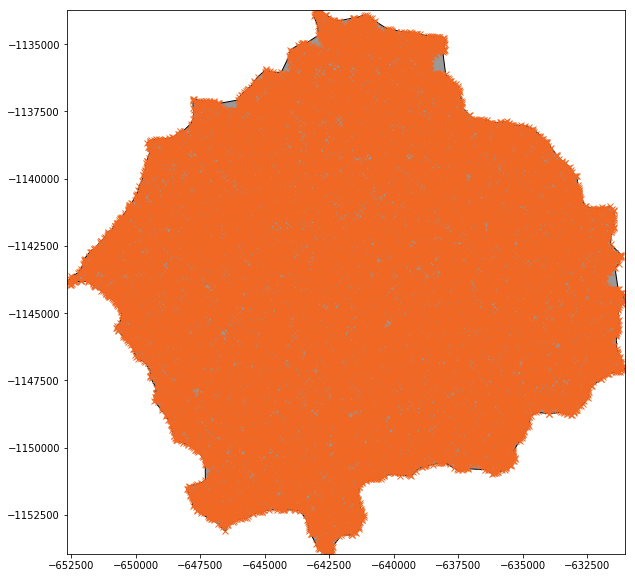

(float) alpha = 80


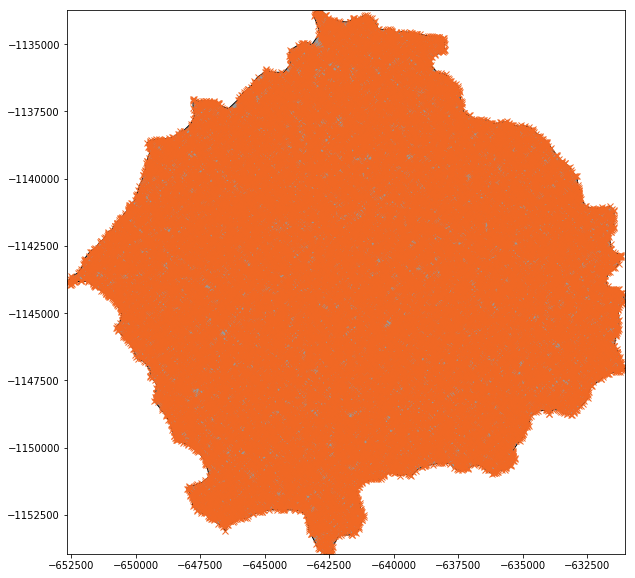

(float) alpha = n
Concave hull output straightened boundary:


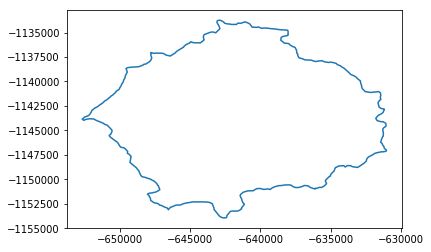

Input alpha value 'n' to break the loop
(float) epsilon: 2e5
Number of boundary points:  2


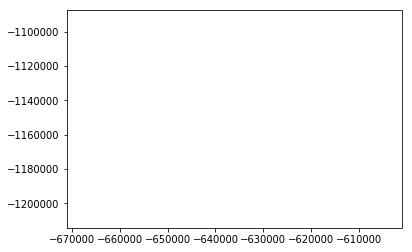

(float) epsilon: 5e2
Number of boundary points:  32


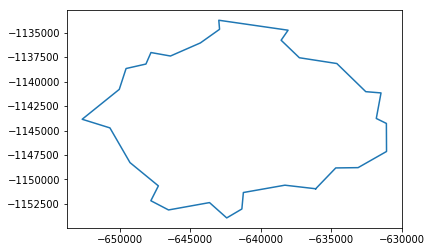

(float) epsilon: 2e2
Number of boundary points:  56


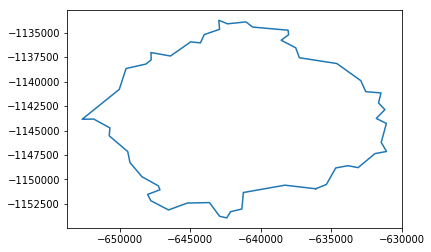

(float) epsilon: 1e2
Number of boundary points:  99


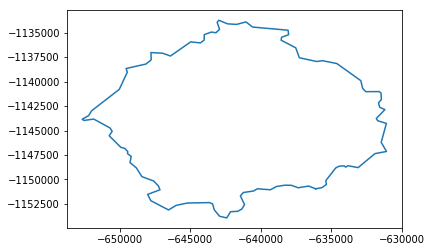

(float) epsilon: 15e1
Number of boundary points:  73


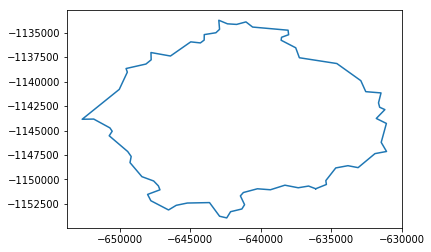

(float) epsilon: 12e1
Number of boundary points:  83


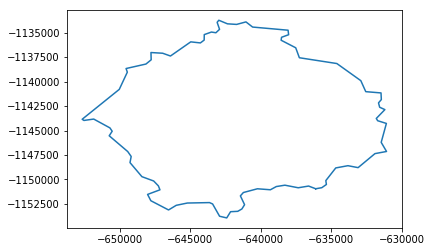

(float) epsilon: 18e1
Number of boundary points:  66


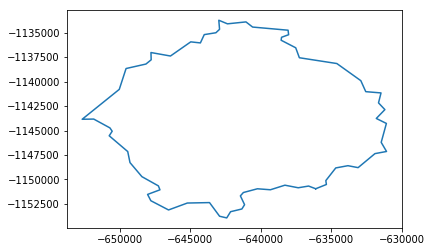

(float) epsilon: n
Final output simplified boundary:


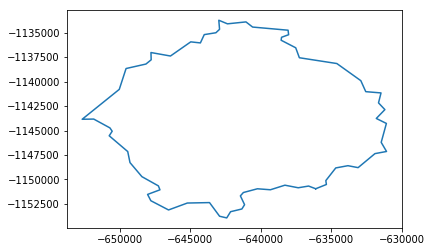

Following list of duplicates found (indeces of duplicates only):  [65]
Wrote 65 points in file: Output/Polygon_points.geo


False

In [42]:
input_shapefile = 'Input/Uzemi_points.shp'
output_geo = 'Output/Polygon_points'
array = straightenBoundary(input_shapefile)
new = simplifyBoundary(array)
new=checkDuplicates(new)
write_polygon_geo(output_geo,new)

In [60]:
from scipy.interpolate import griddata
def func(x, y):
        return x*y/(x**2 + y**2 + 4)

(210, 225)

In [106]:
print((grid_x.shape))
print((p[:,0:2].shape))
print((p[:,2].shape))
print((grid_z0.shape))

(210, 225)
(3895000, 2)
(3895000,)
(210, 225)


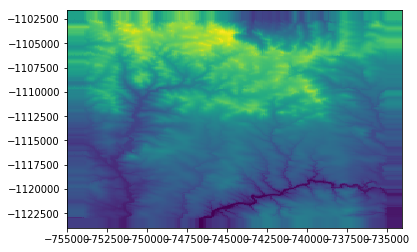

In [113]:
pl.pcolor(grid_x,grid_y,grid_z0)
pl.show()

In [73]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]
# pointsx,pointsy = np.mgrid[0:1:50j, 0:1:100j]
points = np.random.rand(1000, 2)
# values = func(pointsx,pointsy)
values = func(points[:,0],points[:,1])
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')

(100, 200)

In [76]:
# grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]
print((grid_x.shape))
print((points.shape))
print((values.shape))
print((grid_z0.shape))

(100, 200)
(1000, 2)
(1000,)
(100, 200)


In [65]:
print((p[:,0].min()-1000))
print((p[:,0].max()+1000))
print((p[:,1].min()-1000))
print((p[:,1].max()+1000))

-754995.0
-734005.0
-1123995.0
-1101505.0


array([[  4.34000000e+02,  -7.54995000e+05,  -1.12399500e+06],
       [  4.34000000e+02,  -7.54995000e+05,  -1.12389500e+06],
       [  4.34000000e+02,  -7.54995000e+05,  -1.12379500e+06],
       ..., 
       [  6.00160456e+02,  -7.34095000e+05,  -1.10179500e+06],
       [  6.00160456e+02,  -7.34095000e+05,  -1.10169500e+06],
       [  6.00160456e+02,  -7.34095000e+05,  -1.10159500e+06]])